<img src="網路架構.png" style="width:1300px;height:700px;float:middle">

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import tensorflow as tf
import math
import matplotlib.pyplot as plt

In [2]:
data_dir = 'data.data'
f = open(data_dir , 'r' , encoding = 'utf-8')
all_data = f.read()
data = []
for text in all_data.split(':'):
    if len(text) > 0:
        data.append(text.split())
f.close()

In [3]:
# b代表開頭，i代表開頭以後的字
# 文本 :   斯     洛     伐      克
# tag :  b-loc  i-loc  i-loc   i-loc

tags = ['o' ,               # 其他
        'b-per' , 'i-per' , # 人
        'b-loc' , 'i-loc' , # 位置
        'b-org' , 'i-org']  # 公司

tag_to_idx = {'tag_pad' : 0 ,
              'o' : 1 ,
              'b-per' : 2 , 'i-per' : 3 ,
              'b-loc' : 4 , 'i-loc' : 5 ,
              'b-org' : 6 , 'i-org' : 7}
idx_to_tag = dict(zip(tag_to_idx.values() , tag_to_idx.keys()))

In [4]:
# 計算詞頻
word_counts = {}
for sentence in data:
    for word in sentence:
        word_lower = word.lower()
        if word_lower not in tags:
            if word_lower not in word_counts.keys():
                word_counts[word_lower] = 1
            else:
                word_counts[word_lower] += 1

vocab = [word for word , count in word_counts.items() if count >= 2] # 詞頻大於2，才列入考慮

maxlen = max(len(sentence) for sentence in data) # 計算最長句子的長度

In [5]:
word_to_idx = dict((word , index + 2) for index , word in enumerate(vocab))
word_to_idx['pad'] = 0
word_to_idx['unk'] = 1
idx_to_word = dict(zip(word_to_idx.values() , word_to_idx.keys()))

In [6]:
# 將文本內容轉換為index
x_article = []
for sentence in data:
    temp = []
    for word in sentence[::2]:  # 取出偶數項，偶數項為文本內容
        temp.append(word_to_idx.get(word.lower() , word_to_idx['unk']))
    while len(temp) < maxlen:   # 補word_to_idx['pad']，直到長度為maxlen
        temp.append(word_to_idx['pad'])
    x_article.append(temp)
x_article = np.array(x_article)

# 將標籤轉換為index
y_tag = []
for sentence in data:
    temp = []
    for word in sentence[1::2]: # 取出奇數項，奇數項為標籤
        temp.append(tag_to_idx.get(word.lower()))
    while len(temp) < maxlen:   # 補tag_to_idx['tag_pad']，直到長度為maxlen
        temp.append(tag_to_idx['tag_pad'])
    y_tag.append(temp)
y_tag = np.array(y_tag)

In [7]:
indices = np.arange(len(x_article))
np.random.seed(10)
np.random.shuffle(indices)

# 打亂順序
x_article = x_article[indices]
y_tag = y_tag[indices]

# 切分訓練集與測試集
split_at = len(x_article) - len(x_article) // 20
x_article_train , x_article_val = x_article[:split_at] , x_article[split_at:]
y_tag_train , y_tag_val = y_tag[:split_at] , y_tag[split_at:]

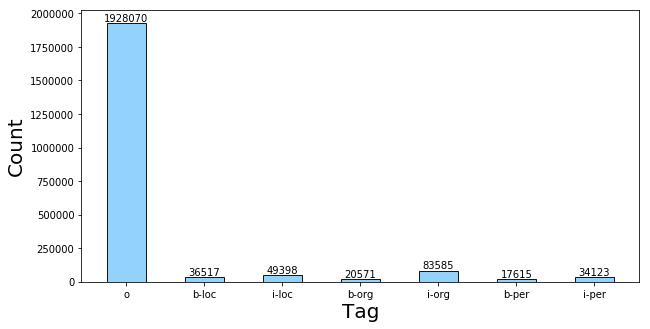

In [8]:
# 計算每種標籤出現的次數
tag_counts = {}
for sentence in data:
    for word in sentence:
        word_lower = word.lower()
        if word_lower in tags:
            if word_lower not in tag_counts.keys():
                tag_counts[word_lower] = 1
            else:
                tag_counts[word_lower] += 1
                
fig , ax = plt.subplots(1 , 1 , figsize = (10 , 5))
ax.bar(tag_counts.keys() , tag_counts.values() , alpha = 0.9 , width = 0.5 , facecolor = 'lightskyblue' , edgecolor = 'black')
plt.xlabel('Tag' , fontsize = 20)
plt.ylabel('Count' , fontsize = 20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

for a , b in zip(tag_counts.keys() , tag_counts.values()):  
    plt.text(a , b + 0.005 , '{}'.format(b), ha = 'center' , va = 'bottom' , fontsize = 10)                

In [9]:
# 文本中標籤為'o'的字實在太多了，所以在計算accuracy時，若是把標籤為'o'的字考慮在內
# 神經網路一定會將大量的字預測為'o'，導致準確率一定會非常高，但這樣根本看不出模型的訓練效果
# 因此本程式中不考慮標籤為'o'的字，只考慮其他標籤是否預測正確(當然也不考慮'tag_pad')
mask_train = np.where((y_tag_train != tag_to_idx['tag_pad']) & (y_tag_train != tag_to_idx['o']) ,
                      np.ones_like(y_tag_train) ,
                      np.zeros_like(y_tag_train))

mask_val = np.where((y_tag_val != tag_to_idx['tag_pad']) & (y_tag_val !=  tag_to_idx['o']) ,
                    np.ones_like(y_tag_val) ,
                    np.zeros_like(y_tag_val))

In [10]:
# 超參數
embedding_size = len(vocab) + 2
embedding_dim = 210
num_layers = 1
batch_size = 64
tag_size = len(tag_to_idx)

In [11]:
# 輸入層
input_data = tf.placeholder(tf.int32 , shape = [None , maxlen] , name = 'input_data')
labels = tf.placeholder(tf.int32 , shape = [None , maxlen] , name = 'labels')
batch_shape = tf.shape(input_data)[0]

word_embedding = tf.get_variable(shape = [embedding_size , embedding_dim] ,
                                 initializer = tf.glorot_uniform_initializer() ,
                                 name = 'word_embedding')
input_embedded = tf.nn.embedding_lookup(word_embedding , input_data)

# 採用雙向LSTM
cell_fw = tf.nn.rnn_cell.LSTMCell(embedding_dim)
cell_bw = tf.nn.rnn_cell.LSTMCell(embedding_dim)
(output_fw , output_bw) , state =\
tf.nn.bidirectional_dynamic_rnn(cell_fw , cell_bw ,
                                input_embedded ,
                                dtype = tf.float32)

bilstm_out = tf.concat([output_fw , output_bw] , axis = 2)

In [12]:
# 全連接層
weight = tf.get_variable(shape = [2 * embedding_dim , tag_size] ,
                         initializer = tf.glorot_uniform_initializer() ,
                         name = 'weight' )

bias = tf.get_variable(shape = [maxlen , tag_size],
                       initializer = tf.zeros_initializer() ,
                       name = 'bias')

bilstm_out = tf.tensordot(bilstm_out , weight , axes = 1) + bias

In [13]:
# 最後在接上一個CRF層
# 假如某個字的標籤序列是 ⇨'b-per' , 'i-per' , 'i-per' , 'i-per'
# 而LSTM的輸出很可能是   ⇨'i-per' , 'b-per' , 'i-per' , 'i-per'
# 而CRF層就是在修正這種錯誤
log_likelihood , transition_params =\
tf.contrib.crf.crf_log_likelihood(bilstm_out ,
                                  labels ,
                                  tf.tile(np.array([maxlen]) , [batch_shape]))

viterbi_sequence , viterbi_score =\
tf.contrib.crf.crf_decode(bilstm_out ,
                          transition_params ,
                          tf.tile(np.array([maxlen]) , [batch_shape]))

In [14]:
loss = tf.reduce_mean(-log_likelihood)
optimizer = tf.train.AdamOptimizer(0.001)
gradients = optimizer.compute_gradients(loss)
train_op = optimizer.apply_gradients(gradients)

In [15]:
# minibatch data index
epochs = 10
num = batch_size
step = (math.ceil(len(x_article_train) / num)) * num
temp = []
j = 0
index = []
for ii in range(0 , step):
    j = j + 1
    if j > len(x_article_train):
        j = j - (len(x_article_train))
    temp.append(j)
    if len(temp) == num:
        index.append(temp)
        temp = []
index = list(np.array(index) - 1)

sess = tf.Session()
sess.run(tf.global_variables_initializer())


# 開始訓練
train_loss_his = []
for epoch_i in range(0 , epochs):
    for batch_i in range(0 , len(index)):
        batch_x_article = x_article_train[index[batch_i] , :]
        batch_y_tag = y_tag_train[index[batch_i] , :]
        _ , train_loss , pred_ner_train =\
        sess.run([train_op , loss , viterbi_sequence] ,
                 feed_dict = {input_data : batch_x_article ,
                              labels : batch_y_tag})

        if batch_i % 200 == 0:
            batch_mask = mask_train[index[batch_i] , :]
            accuracy_train = np.sum((batch_y_tag == pred_ner_train) * batch_mask) / np.sum(batch_mask)

            test_loss , pred_ner_test =\
            sess.run([loss , viterbi_sequence] ,
                      feed_dict = {input_data : x_article_val ,
                                   labels : y_tag_val})
            accuracy_test = np.sum((y_tag_val == pred_ner_test) * mask_val) / np.sum(mask_val)

            print('=' * 30)
            print('epoch_i : {}'.format(epoch_i))
            print('batch_i : {}'.format(batch_i))
            print('training loss : {:.4f}'.format(train_loss))
            print('training_accuracy : {:.2%}'.format(accuracy_train))
            print('testing loss : {:.4f}'.format(test_loss))
            print('testing_accuracy : {:.2%}'.format(accuracy_test))
            train_loss_his.append(train_loss)

epoch_i : 0
batch_i : 0
training loss : 404.5178
training_accuracy : 16.72%
testing loss : 376.6792
testing_accuracy : 14.78%
epoch_i : 0
batch_i : 200
training loss : 13.2999
training_accuracy : 16.93%
testing loss : 13.4082
testing_accuracy : 16.53%
epoch_i : 0
batch_i : 400
training loss : 7.5903
training_accuracy : 52.32%
testing loss : 7.8986
testing_accuracy : 57.08%
epoch_i : 0
batch_i : 600
training loss : 5.6919
training_accuracy : 61.95%
testing loss : 5.6653
testing_accuracy : 66.39%
epoch_i : 1
batch_i : 0
training loss : 4.9995
training_accuracy : 70.67%
testing loss : 4.8881
testing_accuracy : 71.64%
epoch_i : 1
batch_i : 200
training loss : 3.5448
training_accuracy : 78.68%
testing loss : 4.2267
testing_accuracy : 75.09%
epoch_i : 1
batch_i : 400
training loss : 3.4024
training_accuracy : 76.49%
testing loss : 3.7376
testing_accuracy : 77.60%
epoch_i : 1
batch_i : 600
training loss : 3.1604
training_accuracy : 77.88%
testing loss : 3.4013
testing_accuracy : 76.86%
epoch_

In [16]:
article_set , true_tag_set , pred_tag_set = [] , [] , []
for article ,  true_tag , pred_tag in zip(x_article_val , y_tag_val , pred_ner_test):
    temp = []
    for article_idx in article:
        if article_idx == 0: break
        temp.append(idx_to_word[article_idx])    
    article_set.append(temp)
    
    temp = []
    for tag_idx in true_tag:
        if tag_idx == 0: break
        temp.append(idx_to_tag[tag_idx])    
    true_tag_set.append(temp)
    
    temp = []
    for tag_idx in pred_tag:
        if tag_idx == 0: break
        temp.append(idx_to_tag[tag_idx])
    pred_tag_set.append(temp)

In [17]:
article_3 = ''.join(article_set[3])
print('文本內容 :')
print('{}'.format(article_3))
print('\n')

print('真實_Tag : \n{}\n'.format('|'.join(true_tag_set[3])))
print('預測_Tag : \n{}'.format('|'.join(pred_tag_set[3])))

文本內容 :
他们还邀请联合国开发计划署专家潘德克先生讲授交通工程理论，请国内著名交通管理专家讲授交通管理现代化系统及交通信息控制系统理论。


真實_Tag : 
o|o|o|o|o|b-org|i-org|i-org|i-org|i-org|i-org|i-org|i-org|o|o|b-per|i-per|i-per|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o

預測_Tag : 
o|o|o|o|o|b-org|i-org|i-org|i-org|i-org|i-org|i-org|i-org|o|o|b-per|i-per|i-per|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o


In [18]:
article_6 = ''.join(article_set[6])
print('文本內容 :')
print('{}'.format(article_6))
print('\n')

print('真實_Tag : \n{}\n'.format('|'.join(true_tag_set[6])))
print('預測_Tag : \n{}'.format('|'.join(pred_tag_set[6])))

文本內容 :
加剧了黄河下游的断流和水患发生的可能性。


真實_Tag : 
o|o|o|b-loc|i-loc|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o

預測_Tag : 
o|o|o|b-loc|i-loc|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o


In [23]:
article_30 = ''.join(article_set[30])
print('文本內容 :')
print('{}'.format(article_30))
print('\n')

print('真實_Tag : \n{}\n'.format('|'.join(true_tag_set[30])))
print('預測_Tag : \n{}'.format('|'.join(pred_tag_set[30])))

文本內容 :
其中，十分引人注目的是《华尔街日报》一改百多年来的严肃面孔，推出周末版“标准模式”；


真實_Tag : 
o|o|o|o|o|o|o|o|o|o|o|o|b-org|i-org|i-org|i-org|i-org|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o

預測_Tag : 
o|o|o|o|o|o|o|o|o|o|o|o|b-org|i-org|i-org|i-org|i-org|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o|o


In [34]:
article_71 = ''.join(article_set[71])
print('文本內容 :')
print('{}'.format(article_71))
print('\n')

print('真實_Tag : \n{}\n'.format('|'.join(true_tag_set[71])))
print('預測_Tag : \n{}'.format('|'.join(pred_tag_set[71])))

文本內容 :
1996年的欧洲杯赛又减到28％。


真實_Tag : 
o|o|o|o|o|o|b-loc|i-loc|o|o|o|o|o|o|o|o|o

預測_Tag : 
o|o|o|o|o|o|b-loc|i-loc|o|o|o|o|o|o|o|o|o
